In [6]:
from random import random
import numpy as np
import mpmath as mp
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
from sympy import symbols, exp, laplace_transform, inverse_laplace_transform, solve
from scipy.integrate import quad
from scipy.optimize import root_scalar
import heapq
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep", n_colors=13)
np.random.seed(77)

In [7]:
def sim_clock(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True) for _c in c]
    return c, hr_clock

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def clock_irm(lmb, tc): 
    x = lmb * tc
    pm_i = 1.0/(1 + x*np.exp(x))
    pm = np.sum(lmb*pm_i)      
    occ = np.sum(lmb*pm_i*np.exp(x))    
    C = (tc * occ)
    ph = (1 - pm)
    return C, ph

def clock_he(lmb, tc, eps=1e-5, max_rounds=2000):
    lam = np.asarray(lmb, dtype=np.float64).ravel()
    lam /= lam.sum()
    M = len(lam)
    one_minus = 1.0 - lam
    # Upper‐left: (I - Λ)
    UL = np.diag(one_minus)
    # Upper‐right: λ · λ^T   (since r_j = λ_j)
    UR = lam[:, None] * lam[None, :]
    # Lower‐left: zero
    LL = np.zeros((M, M))
    # Lower‐right: (I - Λ) + (λ · λ^T)
    LR = np.diag(one_minus) + lam[:, None] * lam[None, :]
    P = np.block([[UL, UR],
                  [LL, LR]]) 
    p = np.concatenate([lam, np.zeros(M)]) 
    R_L, H_L, O_L = 1.0, 0.0, 1.0
    for _ in range(max_rounds):
        hits = 0.0
        p_t = p.copy()
        for _ in range(int(tc)):
            hits += np.dot(lam, p_t[:M] + p_t[M:])
            p_t = p_t.dot(P)
        P_evict = p_t[:M].sum()
        R_next  = 1.0 - P_evict
        H_L += R_L * hits
        R_L *= R_next
        O_L += R_L
        if R_L < eps or R_next == 0.0:
            break
        survivors = p_t[M:]     
        rho_next = survivors / R_next
        p = np.concatenate([rho_next, np.zeros(M)])
    P_miss = 1.0 / (1.0 + H_L)
    C = int(round(tc * O_L * P_miss))
    return C, 1.0 - P_miss

def fifo_irm(lmb, tc):
    pm = np.sum(lmb/(1 + lmb*tc))
    C = tc * pm
    ph = 1 - pm
    return C, ph

# def fifo_he(lmb, tc): 
#     s, t = symbols('s t', positive=True)
#     F_s = sum((li**2) / (s * (s + li)) for li in lmb)
#     f_s = sum((li**2) / (s + li) for li in lmb)
#     m_s = F_s / (1 - f_s)
#     m_t = inverse_laplace_transform(m_s, s, t)
#     m_tc = float(m_t.subs(t, tc))
#     P_miss = 1.0 / (1.0 + m_tc)
#     C = tc * P_miss
#     return C, 1.0 - P_miss

# def fifo_he(lmb, tcs, dt=0.05):
#     tcs = np.asarray(tcs, dtype=float)
#     def _m_grid(lmb, t_max, dt):
#         lam = np.asarray(lmb, dtype=np.float64).ravel()
#         lam /= lam.sum()
#         t_grid = np.arange(0.0, t_max + dt, dt)
#         exp = np.exp(-lam[:, None] * t_grid[None, :])
#         F = 1.0 - (lam[:, None] * exp).sum(axis=0)
#         f = (lam[:, None] ** 2 * exp).sum(axis=0)
#         m = np.zeros_like(t_grid)
#         for i in range(1, len(t_grid)):
#             conv = np.dot(m[i-1::-1], f[1:i+1])
#             m[i] = F[i] + dt * conv
#         return t_grid, m
#     t_grid, m = _m_grid(lmb, float(np.max(tcs)), dt)
#     m_tc = np.interp(tcs, t_grid, m)
#     P_miss = 1.0 / (1.0 + m_tc)
#     C = tcs * P_miss
#     return C, 1.0 - P_miss

def fifo_he(lmb, tc, method="talbot"):
    lam = [mp.mpf(x) for x in np.asarray(lmb, dtype=np.float64).ravel()]
    t = mp.mpf(tc)
    def _m_of_s(s):
        F = mp.mpf("0")
        f = mp.mpf("0")
        for li in lam:
            li2 = li * li
            F += li2 / (s * (s + li))
            f += li2 / (s + li)
        return F / (1 - f)
    m_tc = mp.invertlaplace(_m_of_s, t, method=method)
    m_tc = float(m_tc)
    P_miss = 1.0 / (1.0 + m_tc)
    C = tc * P_miss
    return C, 1.0 - P_miss

def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

def gen_from_he(m, a, n):
    p = 1.0 / np.power(np.arange(1, m + 1), a)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap)
    trace = np.empty(n, dtype=np.int32)
    for idx in range(n):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_taus(tau_max, N, power=0.8):
    # Uniform grid in [0,1] raised to 'power' >1 compresses values toward 0
    return tau_max * (np.linspace(0.1, 1, N) ** power)

In [ ]:
ms = [30, 60, 120, 240, 480, 960]
n = 10000000
alphas = [0.5, 0.8, 1.1]

records = []
errors = []

for m in ms:
    taus = gen_taus(m * 1.5, 10, power=0.8)
    for a in alphas:
        lmb, trc_irm = gen_from_zipf(m, n, a)
        trc_he = gen_from_he(m, a, n)      

        for tc in taus:
            cc_c_irm_pred, cc_hr_irm_pred = clock_irm(lmb, tc)
            cc_hr_irm_sim = tg.sim_clock(int(cc_c_irm_pred), trc_irm, raw=True, K=1)

            f_c_irm_pred, fc_hr_irm_pred = fifo_irm(lmb, tc)
            fc_hr_irm_sim = tg.sim_fifo(int(f_c_irm_pred), trc_irm, raw=True)

            cc_c_he_pred, cc_hr_he_pred = clock_he(lmb, tc)
            cc_hr_he_sim = tg.sim_clock(int(cc_c_he_pred), trc_he, raw=True, K=1)

            f_c_he_pred, fc_hr_he_pred = fifo_he(lmb, tc)
            fc_hr_he_sim = tg.sim_fifo(int(f_c_he_pred), trc_he, raw=True)

            records.extend([
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "IRM", "method": "CLOCK",
                 "C_pred": cc_c_irm_pred, "hr_pred": cc_hr_irm_pred, "hr_sim": cc_hr_irm_sim},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "IRM", "method": "FIFO",
                 "C_pred": f_c_irm_pred, "hr_pred": fc_hr_irm_pred, "hr_sim": fc_hr_irm_sim},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "HE", "method": "CLOCK",
                 "C_pred": cc_c_he_pred, "hr_pred": cc_hr_he_pred, "hr_sim": cc_hr_he_sim},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "HE", "method": "FIFO",
                 "C_pred": float(f_c_he_pred), "hr_pred": float(fc_hr_he_pred), "hr_sim": fc_hr_he_sim},
            ])

            errors.extend([
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "IRM", "method": "CLOCK",
                 "error": abs(cc_hr_irm_pred - cc_hr_irm_sim)},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "IRM", "method": "FIFO",
                 "error": abs(fc_hr_irm_pred - fc_hr_irm_sim)},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "HE", "method": "CLOCK",
                 "error": abs(cc_hr_he_pred - cc_hr_he_sim)},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "HE", "method": "FIFO",
                 "error": abs(fc_hr_he_pred - fc_hr_he_sim)},
            ])

df_pred = pd.DataFrame(records)
df_err = pd.DataFrame(errors)


In [31]:
# df_pred = pd.DataFrame(records)
# df_err = pd.DataFrame(errors)

# df_pred.to_pickle("df_pred.pkl")
# df_err.to_pickle("df_err.pkl")

df_pred = pd.read_pickle("df_pred.pkl")
df_err = pd.read_pickle("df_err.pkl")


/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() shoul

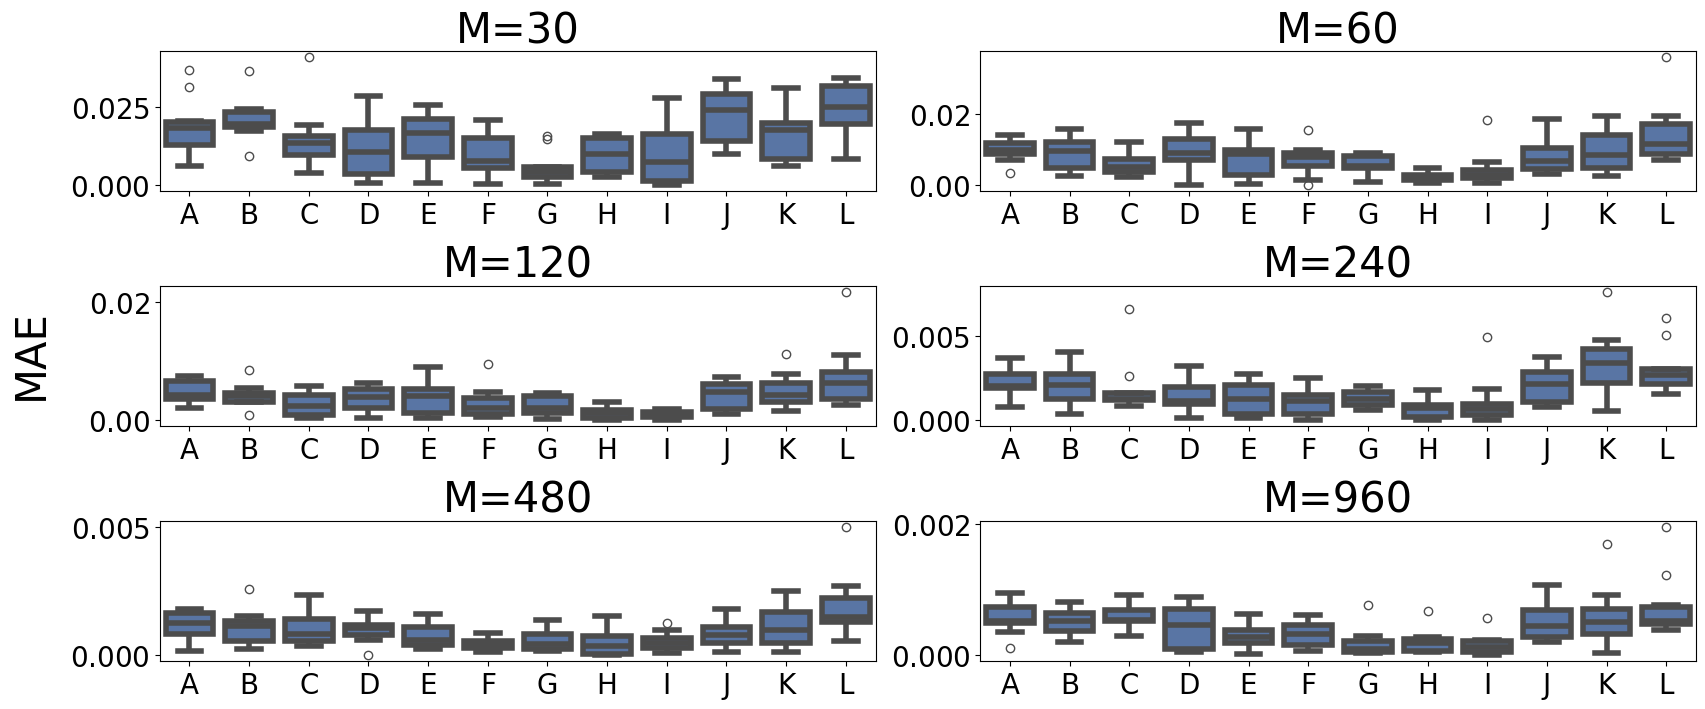

In [81]:
labels = list("ABCDEFGHIJKL")
methods = ["CLOCK", "FIFO"]
wkls = ["IRM", "HE"]
pairs = list(itertools.product(wkls, methods, alphas))

sns.set_palette("deep")
font_axes = 30
font_ticks = 20
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

df_plot = df_err.copy()
df_plot["method_param"] = list(zip(df_plot.workload, df_plot.method, df_plot.alpha))
df_plot["short"] = df_plot["method_param"].map(mapping)

M_list = [30, 60, 120, 240, 480, 960]
n_list = [n]

subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 8),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, (M, n_val) in zip(axes_flat, itertools.product(M_list, n_list)):
    cell = df_plot[(df_plot.m == M) & (df_plot.n == n_val)].copy()
    sns.boxplot(x='short', y='error', data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"M={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=font_axes)

plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
plt.savefig("fifo-clock-maes.pdf", format='pdf')
plt.show()


In [ ]:
# hot/cold
r = 0.8
f = 0.2
M = 10000
lh = r / f / M
lc = (1 - r) / (1 - f) / M
lmb = [lh, lc]


In [3]:
# CLOCK IRM:

def clock_irm_hc(f,m,r,tc):
    lambdaH = r/(f*m)
    lambdaC = (1-r)/((1-f)*m)
    Ch = symbols('Ch')
    Cc = symbols('Cc')
    solution = solve(((1-(1/(1+(lambdaH*tc/exp(-lambdaH*tc))))-Ch/f/m), 1-(1/(1+(lambdaC*tc/exp(-lambdaC*tc))))-Cc/((1-f)*m)),Cc,Ch)
    c = solution[Cc]+solution[Ch]
    phit = r*solution[Ch]/f/m + (1-r)*solution[Cc]/(1-f)/m
    return int(c), phit

# CLOCK HE:

def fh(h,lh,lc,t):
    return (exp(-(lh*t) - lc*r*t + lh*r*t)*(-(h*lh) + lc*r - exp((lh + lc*r - lh*r)*t)*lc*r - h*lc*r + h*lh*r))/(-lh - lc*r + lh*r)

def pha0(pp,lh,lc,tc):
    return (pp*exp(-lh*tc))

def pca0(pp,lh,lc,tc):
    return ((1-pp)*exp(-lc*tc))

def pha1(pp,lh,lc,t):#solved with the 4-state differential equation
    denominator = -lh - lc * r + lh * r
    exponential_term = exp((lh * (-1 + r) - lc * r) * t)
    expression_term = (pp * lh - exp((lc - lh) * r * t) * pp * lh - lc * r + exp(lh * t + (lc - lh) * r * t) * lc * r + pp * lc * r - exp((lc - lh) * r * t) * pp * lc * r - pp * lh * r + exp((lc - lh) * r * t) * pp * lh * r)
    return -(1 / denominator) * exponential_term * expression_term

def pca1(pp,lh,lc,tc):
    return 1-pha0(pp,lh,lc,tc)-pca0(pp,lh,lc,tc)-pha1(pp,lh,lc,tc)

def ph_after_evict(pp,lh,lc,tc):
    return pha1(pp,lh,lc,tc)/(pha1(pp,lh,lc,tc)+pca1(pp,lh,lc,tc))

def pevict(pp,lh,lc,tc):
    return pha0(pp,lh,lc,tc)+pca0(pp,lh,lc,tc)

def p_recycle(pp,lh,lc,tc):
    return pha1(pp,lh,lc,tc)+pca1(pp,lh,lc,tc)

def num_renewals(h, lh, lc, tc):
    integrand = lambda t: lh*fh(h,lh,lc,t) + lc*(1 - fh(h,lh,lc,t))
    val, err = quad(integrand, 0, tc)
    return val

def Occupancy(r, lh, lc, tc):
    eps = 1e-5
    pp = r
    R  = 1.0
    O  = R
    hits = 0.0
    while R >= eps:
        renewals = num_renewals(pp, lh, lc, tc)
        hits    += R * renewals
        R  *= p_recycle(pp, lh, lc, tc)
        O  += R
        pp  = ph_after_evict(pp, lh, lc, tc)
    return O, hits

def clock_he_hc(f,M,r,tc):
    lmdh = r/(f*M)
    lmdc = (1-r)/((1-f)*M)
    O, hits = Occupancy(r,lmdh,lmdc,tc)
    pmiss = 1/(hits+1)
    c = tc * O * pmiss
    return int(c), 1-pmiss

# FIFO IRM:

def fifo_irm_hc(f,m,r,tc):
    lambdaH = r/(f*m)
    lambdaC = (1-r)/((1-f)*m)
    C = symbols('C')
    phmiss = 1/(1+lambdaH*tc)
    pcmiss = 1/(1+lambdaC*tc)
    pmiss = r*phmiss+(1-r)*pcmiss
    solution = solve((C - tc*pmiss),C)[0]
    phit = 1-pmiss
    return int(solution), phit

# FIFO HE:

def fifo_he_hc(f, m, r, tc):
    N_t = lambda t: (-(f - r)**2 + (f - r)**2/np.exp(((-1 + r)*r*t)/((-1 + f)*f*m)) + ((-1 + r)*r*t)/m)/((-1 + r)*r)
    pmiss = 1 / (1 + N_t(tc))
    phit = 1 - pmiss
    c = tc * pmiss
    return int(c), phit

# Trace gen

def gen_from_irm_hc(r, f, M, n):
    trc = np.zeros(n, dtype=np.int32)
    for i in range(n):
        if np.random.random() < r:
            trc[i] = np.random.randint(0, int(f*M))
        else:
            trc[i] = np.random.randint(int(f*M), M)
    return trc

def gen_from_he_hc(r,f,M,n):
    h = []
    for i in range(M):
        if np.random.random() < r:
            t = np.random.exponential(1/(r/(f*M)))
        else:
            t = np.random.exponential(1/((1-r)/((1-f)*M)))
        heapq.heappush(h, [t,i])        
    a = []
    for i in range(n):
        t0,addr = h[0]
        a.append(addr)
        if np.random.random() < r:
            t = np.random.exponential(1/(r/(f*M)))
        else:
            t = np.random.exponential(1/((1-r)/((1-f)*M)))
        heapq.heapreplace(h, [t0+t,addr])
    return np.array(a, dtype=np.int32)

In [57]:
ms = [1000, 10000] # H/C has algorithmic cost constant in M
n = 10000000
f = 0.2        
r = 0.8

records_hc = []
errors_hc = []

for M in ms:
    trc_irm_hc = gen_from_irm_hc(r, f, M, n)
    trc_he_hc = gen_from_he_hc(r, f, M, n)

    taus = gen_taus(M * 2, 10, power=0.8)

    for tc in taus:
        cc_c_irm_pred, cc_hr_irm_pred = clock_irm_hc(f, M, r, tc)
        cc_hr_irm_sim = tg.sim_clock(int(cc_c_irm_pred), trc_irm_hc, raw=True, K=1)

        f_c_irm_pred, fc_hr_irm_pred = fifo_irm_hc(f, M, r, tc)
        fc_hr_irm_sim = tg.sim_fifo(int(f_c_irm_pred), trc_irm_hc, raw=True)

        cc_c_he_pred, cc_hr_he_pred = clock_he_hc(f, M, r, tc)
        cc_hr_he_sim = tg.sim_clock(int(cc_c_he_pred), trc_he_hc, raw=True, K=1)

        fc_c_he_pred, fc_hr_he_pred = fifo_he_hc(f, M, r, tc)
        fc_hr_he_sim = tg.sim_fifo(int(fc_c_he_pred), trc_he_hc, raw=True)

        records_hc.extend([
            {"m": M, "n": n, "tau": tc,
             "workload": "IRM", "method": "CLOCK",
             "C_pred": cc_c_irm_pred, "hr_pred": cc_hr_irm_pred, "hr_sim": cc_hr_irm_sim},
            {"m": M, "n": n, "tau": tc,
             "workload": "IRM", "method": "FIFO",
             "C_pred": f_c_irm_pred, "hr_pred": fc_hr_irm_pred, "hr_sim": fc_hr_irm_sim},
            {"m": M, "n": n, "tau": tc,
             "workload": "HE", "method": "CLOCK",
             "C_pred": cc_c_he_pred, "hr_pred": cc_hr_he_pred, "hr_sim": cc_hr_he_sim},
            {"m": M, "n": n, "tau": tc,
             "workload": "HE", "method": "FIFO",
             "C_pred": float(fc_c_he_pred), "hr_pred": float(fc_hr_he_pred), "hr_sim": fc_hr_he_sim},
        ])

        errors_hc.extend([
            {"m": M, "n": n, "tau": tc,
             "workload": "IRM", "method": "CLOCK",
             "error": abs(cc_hr_irm_pred - cc_hr_irm_sim)},
            {"m": M, "n": n, "tau": tc,
             "workload": "IRM", "method": "FIFO",
             "error": abs(fc_hr_irm_pred - fc_hr_irm_sim)},
            {"m": M, "n": n, "tau": tc,
             "workload": "HE", "method": "CLOCK",
             "error": abs(cc_hr_he_pred - cc_hr_he_sim)},
            {"m": M, "n": n, "tau": tc,
             "workload": "HE", "method": "FIFO",
             "error": abs(fc_hr_he_pred - fc_hr_he_sim)},
        ])

df_hc = pd.DataFrame(records_hc)
df_err_hc = pd.DataFrame(errors_hc)


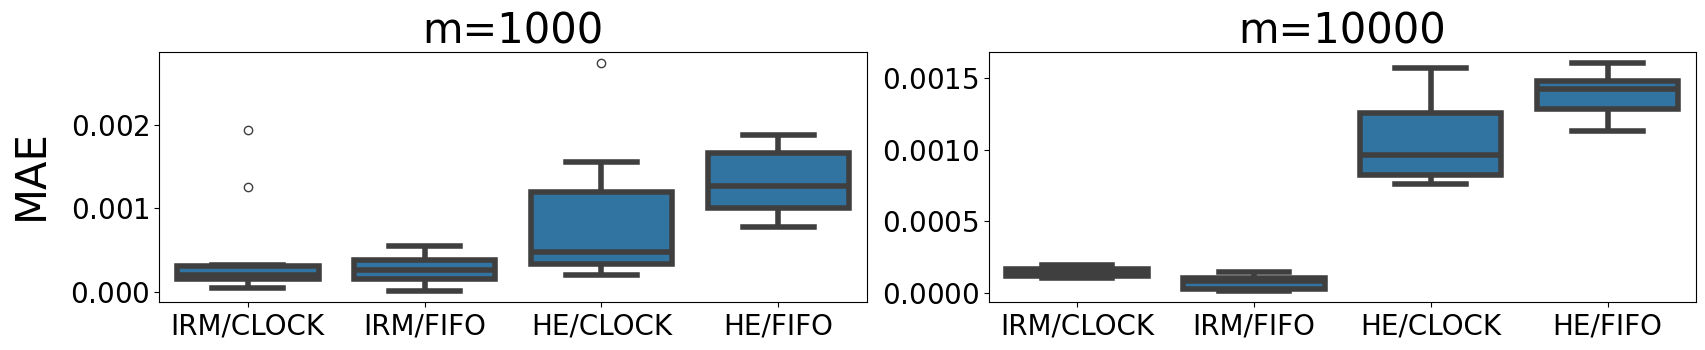

In [58]:
labels = ["IRM/CLOCK", "IRM/FIFO", "HE/CLOCK", "HE/FIFO"]
methods = ["CLOCK", "FIFO"]
wkls = ["IRM", "HE"]
pairs = list(itertools.product(wkls, methods))  # IRM/CLOCK, IRM/FIFO, HE/CLOCK, HE/FIFO
mapping = dict(zip(pairs, labels))

_df = df_err_hc.copy()
_df["error"] = _df["error"].astype(str).str.strip()
_df["error"] = pd.to_numeric(_df["error"], errors="coerce")
_df = _df.dropna(subset=["error"])
_df["workload"] = _df["workload"].astype(str).str.strip()
_df["method"] = _df["method"].astype(str).str.strip()
_df["method_param"] = list(zip(_df.workload, _df.method))
_df["short"] = _df["method_param"].map(mapping)
_df["short"] = pd.Categorical(_df["short"], categories=labels, ordered=True)
order = labels

subplot_rows, subplot_cols = 1, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 4),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, (M, n_val) in zip(axes_flat, itertools.product(ms, [n])):
    cell = _df[(_df.m == M) & (_df.n == n_val)].copy()
    sns.boxplot(x='short', y='error', data=cell, ax=ax2,
                linewidth=4, order=order)
    ax2.set_title(f"m={M}", fontsize=30)
    ax2.tick_params(labelsize=20)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.set_xticks(range(len(order)))
    ax2.set_xticklabels(order, fontsize=20, rotation=0)

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=30)

plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
plt.savefig("fifo-clock-maes-hc.pdf", format='pdf')
plt.show()


In [11]:
# REN

def _solve(r, xh, mh, tc):
    lc = 1 - r
    mh_tc = np.interp(tc, xh, mh)
    phmiss = 1 / (1 + mh_tc)
    pcmiss = 1
    ch = phmiss * tc * r
    cc = lc * tc
    c = ch + cc
    pmiss = r * phmiss + lc * pcmiss
    return int(c), 1 - pmiss


def _mc_renewal(f, t_max, n_bins, n):
    m = np.zeros(n_bins, dtype=int)
    for _ in range(n):
        t = 0
        while True:
            dt = f()
            t += dt
            if dt == -1 or t >= t_max:
                break
            idx = int(n_bins * t / t_max)
            m[idx] += 1
    return np.cumsum(m / n)


def _forward_iad(trace):
    trace2 = np.array(np.flip(trace))
    iads = tg.iad2.iad(trace2)
    return np.flip(iads)


def _normalize_trace(trace):
    trace = np.asarray(trace)
    if trace.ndim == 2:
        # Assume (size, addr) in bytes; convert to cache-line address stream.
        trace = trace.copy()
        trace[:, 0] += 7
        trace = tg.squash(tg.unroll(trace // 8))
        trace = np.asarray(trace)
    elif trace.ndim != 1:
        raise ValueError(f"trace must be 1D or (N,2); got shape {trace.shape}")
    return trace


def _adj_iad(trace):
    trace = _normalize_trace(trace)
    addrs, counts = np.unique(trace, return_counts=True)
    skip = np.zeros(np.max(addrs) + 1, dtype=bool)
    skip[addrs[counts > 1]] = True

    good = np.zeros(len(trace), dtype=bool)
    for j, addr in enumerate(trace):
        if skip[addr]:
            skip[addr] = False
        else:
            good[j] = True

    iads = _forward_iad(trace)
    return iads[good]


def _trunk_iad(trace, size):
    iads = _adj_iad(trace)
    return [iads[i:i + size] for i in range(0, len(iads), size)]


def _cc(iads):
    r = np.sum(iads > -1) / len(iads)
    t_max = len(iads) * 50
    iads = iads[iads > -1]

    mh = _mc_renewal(lambda: np.random.choice(iads), t_max, 3000, 50000)
    print(".")

    xh = np.arange(0, t_max, t_max / 3000)
    phits_model = []
    c1 = []
    for tc in range(0, t_max, 3000):
        c_model, phit_model = _solve(r, xh, mh, tc)
        c1.append(c_model)
        phits_model.append(phit_model)
    return c1, phits_model


def trunk_avg(full_trace, size):
    trunks = _trunk_iad(full_trace, size)
    c, phits = [], []
    for iads in trunks:
        c1, phits_model = _cc(iads)
        c.append(c1)
        phits.append(phits_model)
    c_avg = [sum(sublist) / len(sublist) for sublist in zip(*c)]
    phits_avg = [sum(sublist) / len(sublist) for sublist in zip(*phits)]
    return c_avg, phits_avg


In [15]:
w26 = np.load('../data/w26.npy')
w26[:, 0] += 7
w26 = tg.squash(tg.unroll(w26 // 8))

c_avg_w26, phits_avg_w26 = trunk_avg(w26, size = 400000)


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [ ]:
# np.save("/opt/traces/w26/fifo_c_avg_w26", c_avg_w26)
# np.save("/opt/traces/w26/fifo_phits_avg_w26", phits_avg_w26)

# c_avg_w26 = np.load("../data/FIFO/fifo_c_avg_w26.npy")
# phits_avg_w26 = np.load("../data/FIFO//fifo_phits_avg_w26.npy")

# c_, phits_sim, phits_model = [],[],[]
# for i in range(0, len(c_avg_w26),100):
#     phit= tg.sim_fifo(int(c_avg_w26[i]), w26, raw=True)
#     c_.append(c_avg_w26[i])
#     phits_sim.append(phit)
#     phits_model.append(phits_avg_w26[i])
    
# np.save("../data/FIFO/fifo_c_avg_w26.npy", c_)
# np.save("../data/FIFO/fifo_sim_phits_w26.npy", phits_sim)
# np.save("../data/FIFO/fifo_model_phits_w26.npy", phits_model)


In [23]:
w07 = np.load('../data/w07.npy')
w07 = w07[:len(w07)*3//8]
c_avg_w07, phits_avg_w07 = trunk_avg(w07,size=400000)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [27]:
c_w07, phits_sim_w07, phits_model_w07 = [],[],[]
for i in range(0, len(c_avg_w07),100):
    phit= tg.sim_fifo(int(c_avg_w07[i]), w07, raw = True)
    c_w07.append(c_avg_w07[i])
    phits_sim_w07.append(phit)
    phits_model_w07.append(phits_avg_w07[i])

# np.save('data/FIFO/FIFO_phits_w07_prediction.npy', phits_model_w07, allow_pickle=True)
# np.save('data/FIFO/FIFO_phits_w07_simulation.npy', phits_sim_w07, allow_pickle=True)
# np.save('data/FIFO/FIFO_cachesizes_w07.npy', c_w07, allow_pickle=True)

In [ ]:
phits_model_w07 = np.load('../data/FIFO/FIFO_phits_w07_prediction.npy')
phits_sim_w07 = np.load('../data/FIFO/FIFO_phits_w07_simulation.npy')
c_w07 = np.load('../data/FIFO/FIFO_cachesizes_w07.npy')

In [32]:

def mc_clock(trace):
    items,counts = np.unique(trace,return_counts=True)
    rev = np.array(trace[::-1],dtype=np.int32)
    irt = tg.iad(rev)
    irt = irt[::-1]
    ii = irt[irt>-1]
    n1 = np.sum(counts==1)
    ii = np.append(ii, np.ones(n1)*-1)
    def t_ii():
        return np.random.choice(ii)
    def MC_clock(f, tc, N):
        hits,misses,passes = 0,0,0
        for i in range(N):
            t = 0
            misses += 1
            passes += 1
            next =tc 
            _t = f()
            if _t == -1 or _t > next:
                continue
            t += _t
            hits += 1
            while True:
                _t = t_ii()
                if _t == -1:
                    break
                t += _t
                if t > next+tc:
                    break
                hits += 1
                if t > next:
                    next +=tc 
                    passes += 1
        ph = hits/(hits+misses)
        pm = 1-ph
        np = passes/N
        _C = np * tc * pm
        return ph,_C,np
    rs = np.sum(counts==1) / len(trace)
    hot = items[counts>20]
    hot_i = np.zeros(np.max(items)+1)
    for i in hot:
        hot_i[i] = True
    hot_a = np.array(hot_i[trace],dtype=bool)
    iad_hot = irt[hot_a]
    # iad_hot = iad_hot[iad_hot>-1]
    iad_cold = irt[np.logical_not(hot_a)]
    # iad_cold = iad_cold[iad_cold>-1]
    def t_hot():
        return np.random.choice(iad_hot)
    def t_cold():
        return np.random.choice(iad_cold)  
    tc = np.arange(100000,4000000,50000)
    # hr_sim = [sim_clock(_tc,trace) for _tc in tc]
    aa_hot = np.array([MC_clock(t_hot, _tc, 100000) for _tc in tc])
    aa_cold = np.array([MC_clock(t_cold, _tc, 100000) for _tc in tc])
    rh = np.sum(hot_a) / len(trace)
    rc = 1 - rs - rh
    #3 freq classes
    _C = tc*rs + aa_hot[:,1]*rh + aa_cold[:,1]*rc
    _hr = aa_hot[:,0]*rh + aa_cold[:,0]*rc
    return _C, _hr


In [ ]:
# w26 = np.loadtxt('/mnt/oldssd/opt/traces/w26_r.txt',dtype=np.int32)
# w26[:,0] += 7
# w26 = tg.squash(tg.unroll(w26//8))

# c_cc_w26, hr_cc_w26 = mc_clock(w26)
# hr_w26_sim = [tg.sim_clock(int(c_),w26, raw=True) for c_ in c_cc_w26]

# np.save('../data/CLOCK/CLOCK_phits_w26_prediction.npy',hr_cc_w26)
# np.save('../data/CLOCK/CLOCK_c_w26_prediction.npy',c_cc_w26)
# np.save('../data/CLOCK/CLOCK_phits_w26_simulation.npy',hr_w26_sim)
c26 = np.load('../data/CLOCK/CLOCK_c_w26_prediction.npy')
hr26 = np.load('../data/CLOCK/CLOCK_phits_w26_prediction.npy')
hr26_sim = np.load('../data/CLOCK/CLOCK_phits_w26_simulation.npy')


In [39]:
w07 = np.load('../data/w07.npy')
w07 = w07[:len(w07)*3//8]
c_cc_w07, hr_cc_w07 = mc_clock(w07)
hr_w07_sim = [tg.sim_clock(int(c_),w07, raw=True) for c_ in c_cc_w07]

In [ ]:
# np.save('../data/CLOCK/CLOCK_phits_w07_prediction.npy',hr_cc_w07)
# np.save('../data/CLOCK/CLOCK_c_w07_prediction.npy',c_cc_w07)
# np.save('../data/CLOCK/CLOCK_phits_w07_simulation.npy',hr_w07_sim)

c07 = np.load('../data/CLOCK/CLOCK_c_w07_prediction.npy')
hr_cc_w07 = np.load('../data/CLOCK/CLOCK_phits_w07_prediction.npy')
hr_w07_sim = np.load('../data/CLOCK/CLOCK_phits_w07_simulation.npy')

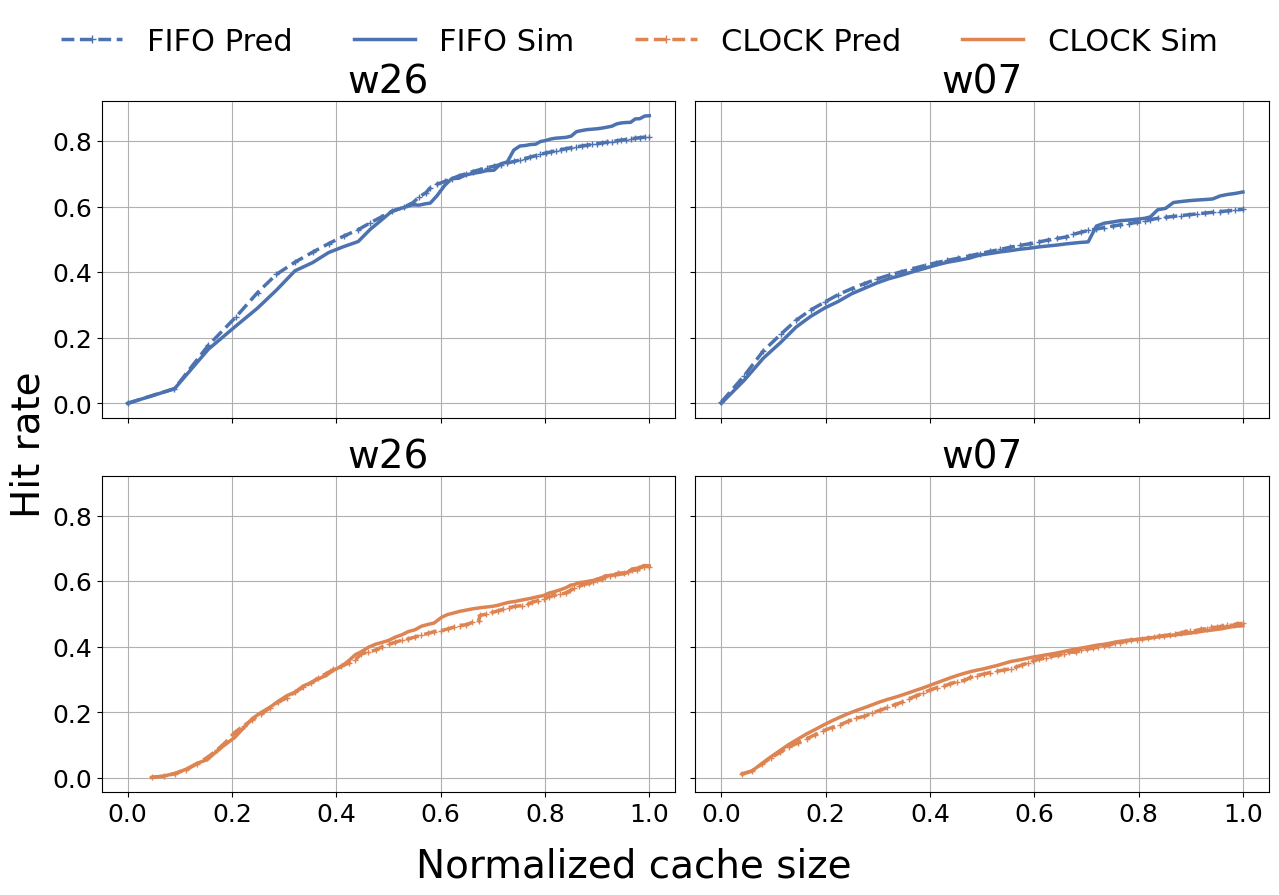

In [52]:

fig, axs = plt.subplots(2, 2, figsize=(13, 9), sharex=True, sharey=True)

fifo_color = palette[0]
clock_color = palette[1]

def _norm_xy(c, y_pred, y_sim):
    n = min(len(c), len(y_pred), len(y_sim))
    c_n = c[:n]
    x = c_n / np.max(c_n)
    return x, y_pred[:n], y_sim[:n]

# FIFO w26
ax = axs[0, 0]
x, y_pred, y_sim = _norm_xy(c26, h26r_pred, hr26_sim)
ax.plot(x, y_pred, linestyle='--', marker='+', markersize=4, linewidth=2.5, color=fifo_color, label='FIFO Pred')
ax.plot(x, y_sim, linestyle='-', linewidth=2.5, color=fifo_color, label='FIFO Sim')
ax.set_title('w26', fontsize=28)
ax.grid(True)

# FIFO w07
ax = axs[0, 1]
x, y_pred, y_sim = _norm_xy(c_w07, phits_model_w07, phits_sim_w07)
ax.plot(x, y_pred, linestyle='--', marker='+', markersize=4, linewidth=2.5, color=fifo_color, label='FIFO Pred')
ax.plot(x, y_sim, linestyle='-', linewidth=2.5, color=fifo_color, label='FIFO Sim')
ax.set_title('w07', fontsize=28)
ax.grid(True)

# CLOCK w26
ax = axs[1, 0]
x, y_pred, y_sim = _norm_xy(c_cc_w26, hr_cc_w26, hr_w26_sim)
ax.plot(x, y_pred, linestyle='--', marker='+', markersize=4, linewidth=2.5, color=clock_color, label='CLOCK Pred')
ax.plot(x, y_sim, linestyle='-', linewidth=2.5, color=clock_color, label='CLOCK Sim')
ax.set_title('w26', fontsize=28)
ax.grid(True)

# CLOCK w07
ax = axs[1, 1]
x, y_pred, y_sim = _norm_xy(c_cc_w07, hr_cc_w07, hr_w07_sim)
ax.plot(x, y_pred, linestyle='--', marker='+', markersize=4, linewidth=2.5, color=clock_color, label='CLOCK Pred')
ax.plot(x, y_sim, linestyle='-', linewidth=2.5, color=clock_color, label='CLOCK Sim')
ax.set_title('w07', fontsize=28)
ax.grid(True)

for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=18)

fig.supxlabel('Normalized cache size', fontsize=28)
fig.supylabel('Hit rate', fontsize=28)

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=fifo_color, linestyle='--', marker='+', linewidth=2.5, label='FIFO Pred'),
    Line2D([0], [0], color=fifo_color, linestyle='-', linewidth=2.5, label='FIFO Sim'),
    Line2D([0], [0], color=clock_color, linestyle='--', marker='+', linewidth=2.5, label='CLOCK Pred'),
    Line2D([0], [0], color=clock_color, linestyle='-', linewidth=2.5, label='CLOCK Sim'),
]
fig.legend(handles=legend_handles, loc='upper center', ncol=4, fontsize=22, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('figures/real-pred.pdf', format='pdf', bbox_inches='tight')
plt.show()
